# Examples

This notebook gives some simple examples of how to run and use the Finite Amplitude Impulse Response (FAIR) model. For this demonstration we will use the IPython notebook.

In [1]:
%matplotlib inline

In [2]:
import fair
fair.__version__

import numpy as np

from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (16, 9)

The "engine" of FAIR is the `fair_scm` function in the `forward` module.

In [3]:
from fair.forward import fair_scm

## CO2 driven run

### Basic example
Here we show how FAIR can be run with step change CO$_2$ emissions and sinusoidal non-CO$_2$ forcing timeseries. This is a FAIR v1.0-style setup in which CO$_2$ is the only emitted species.

In almost every application of FAIR you will probably want to vary the `emissions` time series going in to `fair_scm`. In CO$_2$-only mode this is a 1D array of CO$_2$ emissions. Setting `useMultigas=False` turns off the emissions from non-CO$_2$ species.

The output from FAIR is a 3-tuple of `(C,F,T)` arrays. In CO$_2$ mode, both `C` (representing CO$_2$ concentrations in ppm) and `F` (total radiative forcing in W m$^{-2}$) are 1D arrays. `T` (temperature change since the pre-industrial) is always output as a 1D array.

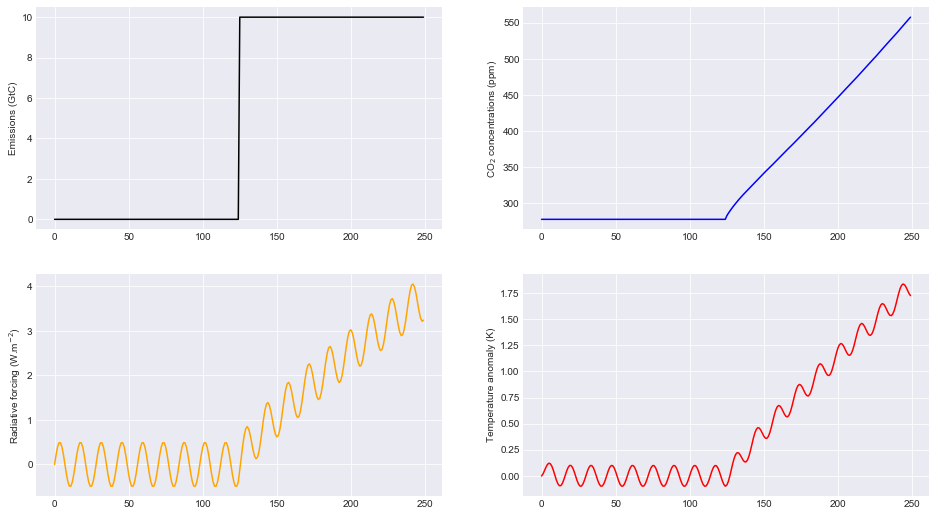

In [4]:
# set up emissions and forcing arrays
emissions = np.zeros(250)   # Unit: GtC
emissions[125:] = 10.0
other_rf = np.zeros(emissions.size)
for x in range(0, emissions.size):
    other_rf[x] = 0.5 * np.sin(2 * np.pi * (x) / 14.0)
    
# run the model
C,F,T = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False
)

# plot the output
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), emissions, color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax2.plot(range(0, emissions.size), C, color='blue')
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0, emissions.size), F, color='orange')
ax3.set_ylabel('Radiative forcing (W.m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0, emissions.size), T, color='red')
ax4.set_ylabel('Temperature anomaly (K)');

### Forcing-only runs
If you want to specify a pure forcing and bypass the carbon cycle routine this is also possible by setting `emissions=False`. This time, we will add a linear forcing to the sinusodal forcing above. Note that the CO$_2$ concentrations are not updated from their pre-industrial value.

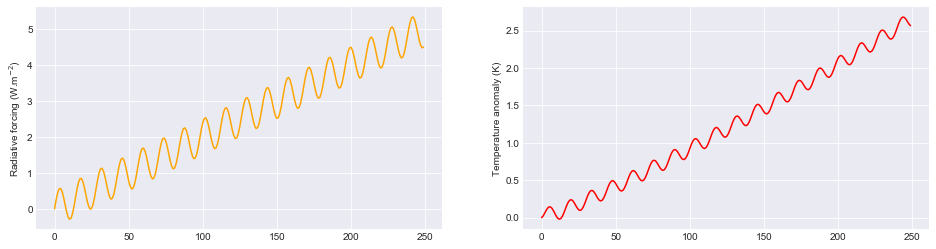

In [5]:
# Define a forcing time series
for x in range(0, emissions.size):
    other_rf[x] = 0.02*x + 0.5 * np.sin(2 * np.pi * (x) / 14.0)
    
# run the model with emissions off
_,F,T = fair.forward.fair_scm(
    emissions=False,
    other_rf=other_rf,
    useMultigas=False
)

# plot the output
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, other_rf.size), F, color='orange')
ax1.set_ylabel('Radiative forcing (W.m$^{-2}$)')
ax1 = fig.add_subplot(222)
ax1.plot(range(0, other_rf.size), T, color='red')
ax1.set_ylabel('Temperature anomaly (K)');

### Varying the carbon cycle parameters
FAIR is set up to simulate the responses to more complex earth system models. This is achieved by a scaling of a four-box decay model for atmospheric carbon dioxide emissions based on the airborne fraction of carbon dioxide. This in turn depends on the efficiency of carbon sinks, which is a function of temperature change and total accumulated carbon uptake. Much of the technical detail is described in [Millar et al., (2017)](https://www.atmos-chem-phys.net/17/7213/2017/acp-17-7213-2017.html).

In the carbon cycle, the important variables are `r0`, `rc` and `rt` which are in turn the pre-industrial sensitivity of carbon sinks, the sensitivity to cumulative carbon dioxide emissions, and sensitivity to temperature change.

This time we will demonstrate with a 10 Gt constant pulse and use a 10-member ensemble.

run      r0     rc    rt
  0  37.484 0.0197 3.821
  1  34.309 0.0210 3.755
  2  38.238 0.0173 4.991
  3  42.615 0.0202 3.877
  4  33.829 0.0204 4.714
  5  33.829 0.0131 4.628
  6  42.896 0.0198 3.668
  7  38.837 0.0143 3.736
  8  32.653 0.0237 4.202
  9  37.713 0.0168 4.430


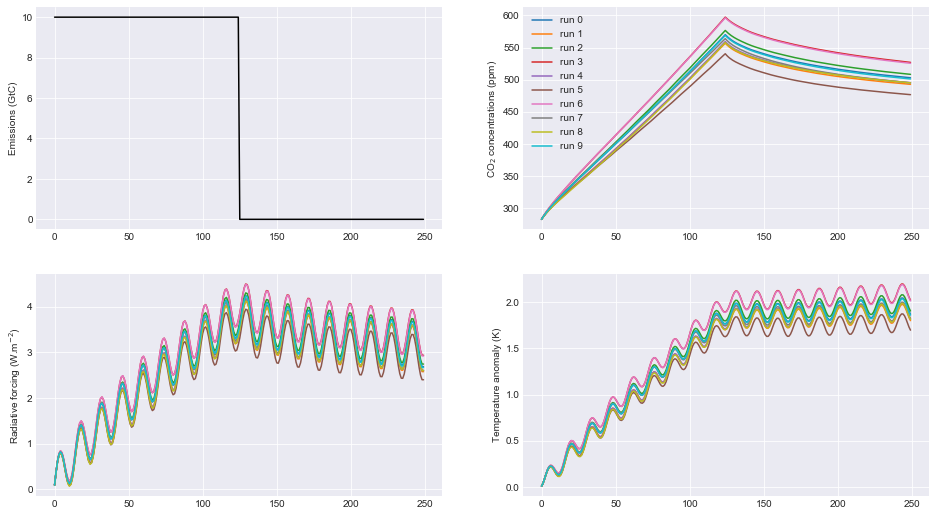

In [6]:
# set up emissions and forcing arrays
emissions = np.ones(250) * 10.0   # Unit: GtC
emissions[125:] = 0.0
other_rf = np.zeros(emissions.size)
for x in range(0, emissions.size):
    other_rf[x] = 0.5 * np.sin(2 * np.pi * (x) / 14.0)

# create output arrays 
nrun = 10
C = np.empty((emissions.size, nrun))
F = np.empty((emissions.size, nrun))
T = np.empty((emissions.size, nrun))

# Generate some random values of carbon cycle parameters
# use a seed for reproducible results
from scipy.stats import norm
r0 = norm.rvs(size=nrun, loc=35, scale=5.0, random_state=42)
rc = norm.rvs(size=nrun, loc=0.019, scale=0.003, random_state=77)
rt = norm.rvs(size=nrun, loc=4.165, scale=0.5, random_state=1729)

# initialise plot
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), emissions, color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
# run the model and plot outputs
print ("run      r0     rc    rt")
for i in range(nrun):
    print ("  %d  %5.3f %5.4f %5.3f" % (i, r0[i], rc[i], rt[i]))
    C[:,i],F[:,i],T[:,i] = fair.forward.fair_scm(
        emissions=emissions,
        other_rf=other_rf,
        useMultigas=False,
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    ax2.plot(range(0, emissions.size), C[:,i], label='run %d' % i)
    ax2.set_ylabel('CO$_2$ concentrations (ppm)')
    ax3.plot(range(0, emissions.size), F[:,i])
    ax3.set_ylabel('Radiative forcing (W.m$^{-2}$)')
    ax4.plot(range(0, emissions.size), T[:,i])
    ax4.set_ylabel('Temperature anomaly (K)');
ax2.legend();

### Changing CO2 lifetime and partitioning coefficients
The CO$_2$ initial lifetime and partitioning coefficients are quantified by the `tau` and `a` parameters respectively. The rationale follows the four-box model in AR5. First we'll run with the defaults and then change them.

In the second figure it can be seen that these parameter settings are important for the rate of decay of atmospheric CO$_2$.

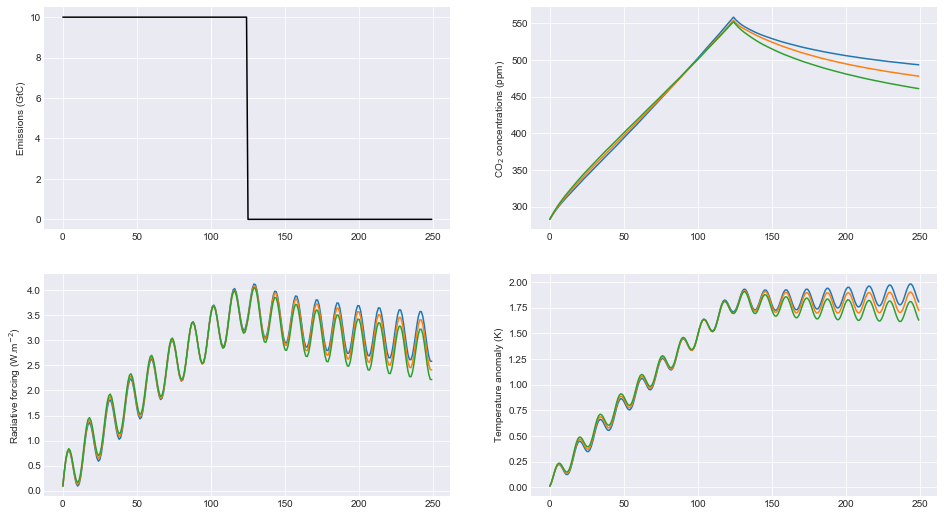

In [7]:
# set up emissions and forcing arrays
emissions = np.ones(250) * 10.0   # Unit: GtC
emissions[125:] = 0.0
other_rf = np.zeros(emissions.size)
for x in range(0, emissions.size):
    other_rf[x] = 0.5 * np.sin(2 * np.pi * (x) / 14.0)

# create output arrays 
nrun=3
C = np.empty((emissions.size, nrun))
F = np.empty((emissions.size, nrun))
T = np.empty((emissions.size, nrun))

# Play with the carbon boxes
tau2 = np.array([1e6, 400.0, 100.0, 5.0])
a2   = np.ones(4) * 0.25

# Nobody said we had to stick to a four-box model...
tau3 = np.array([1e6, 1000.0, 150.0, 70.0, 15.0, 3.0])
a3   = np.array([0.1, 0.2, 0.2, 0.2, 0.2, 0.1])

# run the model for default case
C[:,0],F[:,0],T[:,0] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False)

# ... and for our alternatives
C[:,1],F[:,1],T[:,1] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False,
    tau=tau2,
    a=a2)
C[:,2],F[:,2],T[:,2] = fair.forward.fair_scm(
    emissions=emissions,
    other_rf=other_rf,
    useMultigas=False,
    tau=tau3,
    a=a3)

# plot the output
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), emissions, color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax2.plot(range(0, emissions.size), C)
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0, emissions.size), F)
ax3.set_ylabel('Radiative forcing (W.m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0, emissions.size), T)
ax4.set_ylabel('Temperature anomaly (K)');

### ECS and TCR
The equilibrium climate sensitivity (defined as the equilibrium warming for an abrupt doubling of CO$_2$ concentrations) and transient climate response (defined as the temperature change after a CO$_2$ doubling to a 1% per year compound increase in CO$_2$ concentrations - approximately 70 years) are both key uncertainties in climate science. The temperature response in FAIR depends on both. The `tcrecs` parameter, a 2-element array, controls this.

This next example shows the effect of varying the ECS and TCR. (Note that by definition the case ECS=1.0, TCR=1.75 is not possible, but FAIR can handle such pathological cases!)

The biggest effect is on the temperature response, but as the temperature feeds back into the carbon cycle, this also affects the CO$_2$ concentrations and the radiative forcing.

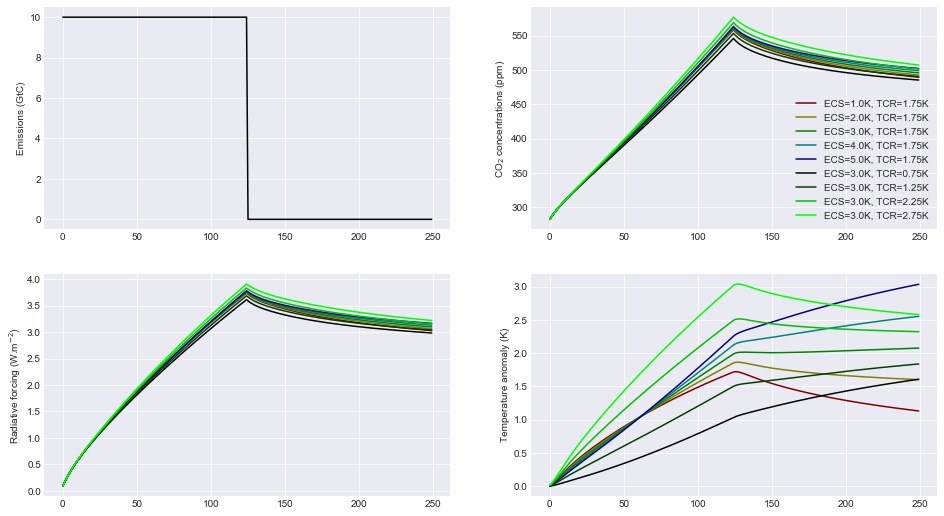

In [9]:
# set up emissions and forcing arrays
emissions = np.zeros(250)
emissions[:125] = 10.0

# create output arrays 
nrun=9
C = np.empty((emissions.size, nrun))
F = np.empty((emissions.size, nrun))
T = np.empty((emissions.size, nrun))

# initialise plot
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), emissions, color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ecs = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 3.0, 3.0, 3.0, 3.0])
tcr = np.array([1.75, 1.75, 1.75, 1.75, 1.75, 0.75, 1.25, 2.25, 2.75])
colors = ['#800000','#808000','#008000','#008080','#000080', '#000000', '#004000', '#00c000', '#00ff00']

# run the model and plot outputs
for i in range(nrun):
    C[:,i],F[:,i],T[:,i] = fair.forward.fair_scm(
        emissions=emissions,
        useMultigas=False,
        tcrecs=[tcr[i], ecs[i]],
    )
    
    ax2.plot(range(0, emissions.size), C[:,i], color=colors[i], label='ECS=%3.1fK, TCR=%4.2fK' % (ecs[i], tcr[i]))
    ax2.set_ylabel('CO$_2$ concentrations (ppm)')
    ax3.plot(range(0, emissions.size), F[:,i], color=colors[i])
    ax3.set_ylabel('Radiative forcing (W.m$^{-2}$)')
    ax4.plot(range(0, emissions.size), T[:,i], color=colors[i])
    ax4.set_ylabel('Temperature anomaly (K)');
ax2.legend();

Some recent studies ([Armour 2017](https://www.nature.com/articles/nclimate3278); [Gregory and Andrews 2016](http://onlinelibrary.wiley.com/doi/10.1002/2016GL068406/abstract)) suggest that ECS and TCR may not be constant. Fortunately we can investigate this in FAIR by specifying `tcrecs` as a two dimensional ((number of years, 2)) array. Notice the effect that a varying ECS/TCR has on the temperature.

(250, 2)


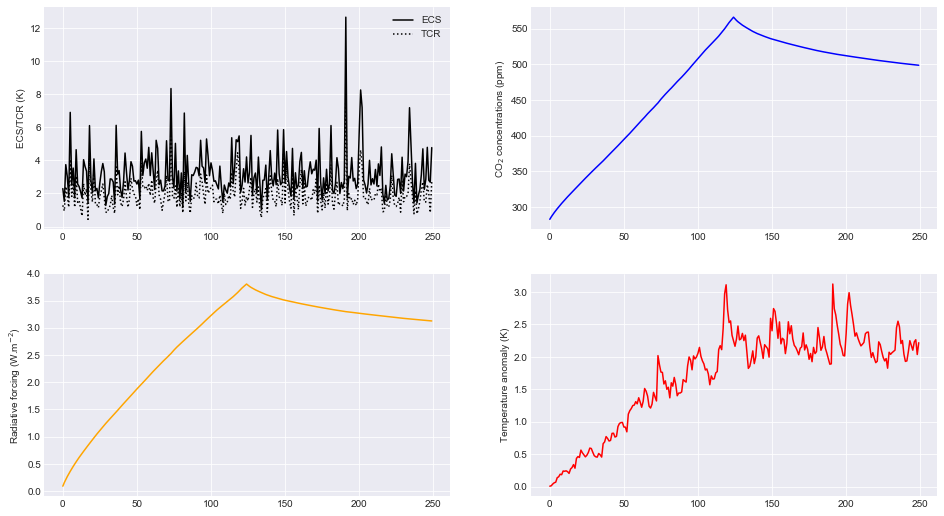

In [11]:
from scipy.stats import lognorm, truncnorm

# generate an ECS time series that roughly follows the AR5 likely range
ecs = lognorm.rvs(0.4, size=250, scale=3, random_state=299)

# define TCR in terms of a realised warming fraction
rwf = truncnorm.rvs(-3, 3, loc=0.6, scale=0.1, size=250, random_state=301)
tcr = rwf*ecs

emissions = np.zeros(250)
emissions[:125] = 10.0

C,F,T = fair.forward.fair_scm(
    emissions=emissions,
    useMultigas=False,
    tcrecs=np.vstack([tcr, ecs]).T,
)

# plot the output
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0, emissions.size), ecs, color='black', label='ECS')
ax1.plot(range(0, emissions.size), tcr, color='black', ls=':', label='TCR')
ax1.legend()
ax1.set_ylabel('ECS/TCR (K)')
ax2 = fig.add_subplot(222)
ax2.plot(range(0, emissions.size), C, color='blue')
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0, emissions.size), F, color='orange')
ax3.set_ylabel('Radiative forcing (W.m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0, emissions.size), T, color='red')
ax4.set_ylabel('Temperature anomaly (K)');

The alternative is to specify the values of `q` directly (a 2D array) that go into the temperature calculation, bypassing `tcrecs` completely (setting `tcrecs=None`). It is not known under what circumstances the user may want to do this, but be assured it's possible!

In [ ]:
# set up emissions and forcing arrays
emissions = np.ones(250) * 10.0
emissions[125:] = 0.0

q = np.ones((250,2))
q[:,0] = 0.2
q[:,1] = 0.6
C,F,T = fair.forward.fair_scm(
    emissions=emissions,
    useMultigas=False,
    tcrecs=None,
    q=q,
)
print (C[-1], F[-1], T[-1])

## Multi-species mode

More interesting scenarios can be created with the full suite of forcing agents. The key changes from CO$_2$-only mode that should be remembered are:

* This time the emissions dataset is a (nt, 40) array of inputs
* `useMultigas` should be set to `True`, or omitted (this is the default option)
* The concentration and forcing outputs are themselves 2-dimensional arrays of size (nt, 31) and (nt, 13) respectively.

### Emissions
Specify an (nt, 40) emissions array. The index order and units of the columns are as follows:

 Index     | Species        | Units                                          
-----------|----------------|------
 0         | Year           | year 
 1         | CO$_2$-fossil  | GtC/yr                                               
 2         | CO$_2$-landuse | GtC/yr                                               
 3         | CH$_4$         | Mt/yr 
 4         | N$_2$O         | MtN$_2$/yr 
 5         | SOx            | MtS/yr 
 6         | CO             | Mt/yr 
 7         | NMVOC          | Mt/yr 
 8         | NOx            | MtN/yr 
 9         | BC             | Mt/yr 
 10        | OC             | Mt/yr 
 11        | NH$_3$         | Mt/yr 
 12        | CF$_4$         | kt/yr 
 13        | C$_2$F$_6$     | kt/yr   
 14        | C$_6$F$_{14}$  | kt/yr   
 15        | HFC23          | kt/yr   
 16        | HFC32          | kt/yr   
 17        | HFC43-10       | kt/yr   
 18        | HFC125         | kt/yr   
 19        | HFC134a        | kt/yr   
 20        | HFC143a        | kt/yr   
 21        | HFC227ea       | kt/yr  
 22        | HFC245fa       | kt/yr   
 23        | SF$_6$         | kt/yr   
 24        | CFC11          | kt/yr   
 25        | CFC12          | kt/yr   
 26        | CFC113         | kt/yr   
 27        | CFC114         | kt/yr   
 28        | CFC115         | kt/yr   
 29        | CCl$_4$        | kt/yr   
 30        | Methyl chloroform | kt/yr   
 31        | HCFC22         | kt/yr    
 32        | HCFC141b       | kt/yr    
 33        | HCFC142b       | kt/yr   
 34        | Halon 1211     | kt/yr   
 35        | Halon 1202     | kt/yr   
 36        | Halon 1301     | kt/yr   
 37        | Halon 2401     | kt/yr   
 38        | CH$_3$Br       | kt/yr 
 39        | CH$_3$Cl       | kt/yr  

The index order of the columns follows that of the RCP datasets at http://www.pik-potsdam.de/~mmalte/rcps/.

## RCPs

We can run FAIR with the CO$_2$ emissions and non-CO$_2$ forcing from the four representative concentration pathway scenarios. To use the emissions-based version specify ```useMultigas=True``` in the call to ```fair_scm()```.

By default in multi-gas mode, volcanic and solar forcing plus natural emissions of methane and nitrous oxide are switched on.

In [ ]:
from fair.RCPs import rcp3pd, rcp45, rcp6, rcp85

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

C26, F26, T26 = fair.forward.fair_scm(emissions=rcp3pd.Emissions.emissions)
ax1.plot(rcp3pd.Emissions.year, rcp3pd.Emissions.co2_fossil, color='green', label='RCP3PD')
ax2.plot(rcp3pd.Emissions.year, C26[:, 0], color='green')
ax3.plot(rcp3pd.Emissions.year, np.sum(F26, axis=1), color='green')
ax4.plot(rcp3pd.Emissions.year, T26, color='green')

C45, F45, T45 = fair.forward.fair_scm(emissions=rcp45.Emissions.emissions)
ax1.plot(rcp45.Emissions.year, rcp45.Emissions.co2_fossil, color='blue', label='RCP4.5')
ax2.plot(rcp45.Emissions.year, C45[:, 0], color='blue')
ax3.plot(rcp45.Emissions.year, np.sum(F45, axis=1), color='blue')
ax4.plot(rcp45.Emissions.year, T45, color='blue')

C60, F60, T60 = fair.forward.fair_scm(emissions=rcp6.Emissions.emissions)
ax1.plot(rcp6.Emissions.year, rcp6.Emissions.co2_fossil, color='red', label='RCP6')
ax2.plot(rcp6.Emissions.year, C60[:, 0], color='red')
ax3.plot(rcp6.Emissions.year, np.sum(F60, axis=1), color='red')
ax4.plot(rcp6.Emissions.year, T60, color='red')

C85, F85, T85 = fair.forward.fair_scm(emissions=rcp85.Emissions.emissions)
ax1.plot(rcp85.Emissions.year, rcp85.Emissions.co2_fossil, color='black', label='RCP8.5')
ax2.plot(rcp85.Emissions.year, C85[:, 0], color='black')
ax3.plot(rcp85.Emissions.year, np.sum(F85, axis=1), color='black')
ax4.plot(rcp85.Emissions.year, T85, color='black')

ax1.set_ylabel('Fossil CO$_2$ Emissions (GtC)')
ax1.legend()
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3.set_ylabel('Total radiative forcing (W.m$^{-2}$)')
ax4.set_ylabel('Temperature anomaly (K)');

## Concentrations of well-mixed greenhouse gases

The output of FAIR (in most cases) is a 3-element tuple of concentrations, effective radiative forcing and temperature change since pre-industrial. Concentrations are a 31-column array of greenhouse gases. The indices correspond to the order given in the RCP concentration datasets (table 2 in Smith et al., https://www.geosci-model-dev-discuss.net/gmd-2017-266/). We can investigate the GHG concentrations coming out of the model:

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(rcp3pd.Emissions.year, C26[:,1], color='green', label='RCP3PD')
ax1.plot(rcp45.Emissions.year, C45[:,1], color='blue', label='RCP4.5')
ax1.plot(rcp6.Emissions.year, C60[:,1], color='red', label='RCP6')
ax1.plot(rcp85.Emissions.year, C85[:,1], color='black', label='RCP8.5')
ax1.set_title("Methane concentrations, ppb")

ax2.plot(rcp3pd.Emissions.year, C26[:,2], color='green', label='RCP3PD')
ax2.plot(rcp45.Emissions.year, C45[:,2], color='blue', label='RCP4.5')
ax2.plot(rcp6.Emissions.year, C60[:,2], color='red', label='RCP6')
ax2.plot(rcp85.Emissions.year, C85[:,2], color='black', label='RCP8.5')
ax2.set_title("Nitrous oxide concentrations, ppb")

# How to convert the H and F gases to single-species equivalents? Weight by radiative efficiency.
from fair.constants import radeff
C26_hfc134a_eq = np.sum(C26[:,3:15]*radeff.aslist[3:15],axis=1)/radeff.HFC134A   # indices 3:15 are HFCs and PFCs
C45_hfc134a_eq = np.sum(C45[:,3:15]*radeff.aslist[3:15],axis=1)/radeff.HFC134A
C60_hfc134a_eq = np.sum(C60[:,3:15]*radeff.aslist[3:15],axis=1)/radeff.HFC134A
C85_hfc134a_eq = np.sum(C85[:,3:15]*radeff.aslist[3:15],axis=1)/radeff.HFC134A

C26_cfc12_eq = np.sum(C26[:,15:31]*radeff.aslist[15:31],axis=1)/radeff.CFC12   # indices 15:31 are ozone depleters
C45_cfc12_eq = np.sum(C45[:,15:31]*radeff.aslist[15:31],axis=1)/radeff.CFC12
C60_cfc12_eq = np.sum(C60[:,15:31]*radeff.aslist[15:31],axis=1)/radeff.CFC12
C85_cfc12_eq = np.sum(C85[:,15:31]*radeff.aslist[15:31],axis=1)/radeff.CFC12

ax3.plot(rcp3pd.Emissions.year, C26_hfc134a_eq, color='green', label='RCP3PD')
ax3.plot(rcp45.Emissions.year, C45_hfc134a_eq, color='blue', label='RCP4.5')
ax3.plot(rcp6.Emissions.year, C60_hfc134a_eq, color='red', label='RCP6')
ax3.plot(rcp85.Emissions.year, C85_hfc134a_eq, color='black', label='RCP8.5')
ax3.set_title("HFC134a equivalent concentrations, ppt")

ax4.plot(rcp3pd.Emissions.year, C26_cfc12_eq, color='green', label='RCP3PD')
ax4.plot(rcp45.Emissions.year, C45_cfc12_eq, color='blue', label='RCP4.5')
ax4.plot(rcp6.Emissions.year, C60_cfc12_eq, color='red', label='RCP6')
ax4.plot(rcp85.Emissions.year, C85_cfc12_eq, color='black', label='RCP8.5')
ax4.set_title("CFC12 equivalent concentrations, ppt")
ax1.legend()

## Radiative forcing
We consider 13 separate species of radiative forcing: CO$_2$, CH$_4$, N$_2$O, minor GHGs, tropospheric ozone, stratospheric ozone, stratospheric water vapour from methane oxidation, contrails, aerosols, black carbon on snow, land use change, volcanic and solar (table 1 in Smith et al., https://www.geosci-model-dev-discuss.net/gmd-2017-266/). Here we show some of the more interesting examples.

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(rcp3pd.Emissions.year, F26[:,4], color='green', label='RCP3PD')
ax1.plot(rcp45.Emissions.year, F45[:,4], color='blue', label='RCP4.5')
ax1.plot(rcp6.Emissions.year, F60[:,4], color='red', label='RCP6')
ax1.plot(rcp85.Emissions.year, F85[:,4], color='black', label='RCP8.5')
ax1.set_title("Tropospheric ozone forcing, W m$^{-2}$")

ax2.plot(rcp3pd.Emissions.year, F26[:,5], color='green', label='RCP3PD')
ax2.plot(rcp45.Emissions.year, F45[:,5], color='blue', label='RCP4.5')
ax2.plot(rcp6.Emissions.year, F60[:,5], color='red', label='RCP6')
ax2.plot(rcp85.Emissions.year, F85[:,5], color='black', label='RCP8.5')
ax2.set_title("Stratospheric ozone forcing, W m$^{-2}$")

ax3.plot(rcp3pd.Emissions.year, F26[:,8], color='green', label='RCP3PD')
ax3.plot(rcp45.Emissions.year, F45[:,8], color='blue', label='RCP4.5')
ax3.plot(rcp6.Emissions.year, F60[:,8], color='red', label='RCP6')
ax3.plot(rcp85.Emissions.year, F85[:,8], color='black', label='RCP8.5')
ax3.set_title("Aerosol forcing, W ~m$^{-2}$")

ax4.plot(rcp3pd.Emissions.year, F26[:,10], color='green', label='RCP3PD')
ax4.plot(rcp45.Emissions.year, F45[:,10], color='blue', label='RCP4.5')
ax4.plot(rcp6.Emissions.year, F60[:,10], color='red', label='RCP6')
ax4.plot(rcp85.Emissions.year, F85[:,10], color='black', label='RCP8.5')
ax4.set_title("Land use forcing, W m$^{-2}$")
ax1.legend();

## Ensemble generation
An advantage of FAIR is that it is very quick to run (much less than a second on an average machine). Therefore it can be used to generate probabilistic future ensembles. We'll show a 100-member ensemble.

In [ ]:
from scipy import stats

# generate some (bad) TCR and ECS pairs
tcrecs = stats.norm.rvs(size=(100,2), loc=[1.75,3], scale=[0.4,0.8], random_state=38571)

# generate some forcing scale factors with SD of 10% of the best estimate
F_scale = stats.norm.rvs(size=(100,13), loc=1, scale=0.1, random_state=40000)

# do the same for the carbon cycle parameters
r0 = stats.norm.rvs(size=100, loc=35, scale=3.5, random_state=41000)
rc = stats.norm.rvs(size=100, loc=0.019, scale=0.0019, random_state=42000)
rt = stats.norm.rvs(size=100, loc=4.165, scale=0.4165, random_state=45000)

T = np.zeros((736,100))

%time
for i in range(100):
    _, _, T[:,i] = fair.forward.fair_scm(emissions=rcp85.Emissions.emissions,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = tcrecs[i,:],
                        scale = F_scale[i,:],
                        F2x = 3.74*F_scale[i,0])   # scale F2x with the CO2 scaling factor for consistency

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(rcp85.Emissions.year, T);

The resulting projections show a large spread. Some of these ensemble members are unrealistic, ranging from around 0.4 to 2.0 K temperature change in the present day, whereas we know in reality it is more like 0.9 (plus or minus 0.2). Therefore we can constrain this ensemble to observations.

In [ ]:
from fair.tools.constrain import hist_temp
CW = np.loadtxt('fair/tools/tempobs/had4_krig_annual_v2_0_0.txt')  # Cowtan & Way in-filled dataset of global temperatures
constrained = np.zeros(100, dtype=bool)
for i in range(100):
    # we use observed trend from 1880 to 2016
    constrained[i] = hist_temp(CW[30:,1], T[1880-1765:2017-1765,i], CW[30:,0])

In [ ]:
# How many ensemble members passed the constraint?
print np.sum(constrained)

In [ ]:
# What does this do to the ensemble?
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(rcp85.Emissions.year, T[:,constrained]);

Some, but not all, of the higher end scenarios have been constrained out, but there is still quite a large range of total temperature change projected for 2500 even under this constraint.

From these constraints it is possible to obtain posterior distributions on effective radiative forcing, ECS, TCR, TCRE and other metrics.